In [ ]:
# worldcam correction testing
# pulled from analyze_ephys.py
# TO DO: organize into a usable function at some point

In [22]:
cd t:\freely_moving_ephys\ephys_recordings\112920\G6H27P8LT\fm1

t:\freely_moving_ephys\ephys_recordings\112920\G6H27P8LT\fm1


In [27]:
name_base = '112920_G6H27P8LT_control_Rig2_fm1_pupil_rotation_rep11'

eye_file = name_base + 'Reye.nc'
world_file = name_base + '_world.nc'
ephys_file = name_base + '_ephys_merge.json'
imu_file = name_base + "_imu.nc"
speed_file = name_base + "_speed.nc"

#free_move = True; has_imu = True; has_mouse = False;
free_move = True; has_imu = True; has_mouse = True;
stim_type = 'grat'

In [28]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pickle
import time
import subprocess
from matplotlib.animation import FFMpegWriter
import matplotlib as mpl 
import wavio
mpl.rcParams['animation.ffmpeg_path'] = r'C:\Program Files\ffmpeg\bin\ffmpeg.exe'
from scipy.interpolate import interp1d
from numpy import nan
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from scipy.ndimage import shift as imshift
from scipy import signal
from sklearn.cluster import KMeans

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [29]:
world_data = xr.open_dataset(world_file)
world_vid_raw = np.uint8(world_data['WORLD_video'])
sz = world_vid_raw.shape
downsamp = 0.5
world_vid = np.zeros((sz[0],np.int(sz[1]*downsamp),np.int(sz[2]*downsamp)), dtype = 'uint8')
for f in range(sz[0]):
    world_vid[f,:,:] = cv2.resize(world_vid_raw[f,:,:],(np.int(sz[2]*downsamp),np.int(sz[1]*downsamp)))
worldT = world_data.timestamps.copy()
world_data

<xarray.Dataset>
Dimensions:      (frame: 78707, height: 240, width: 320)
Coordinates:
  * frame        (frame) int64 0 1 2 3 4 5 ... 78702 78703 78704 78705 78706
    timestamps   (frame) float64 ...
Dimensions without coordinates: height, width
Data variables:
    WORLD_times  (frame) float64 ...
    WORLD_video  (frame, height, width) int8 17 117 96 101 ... 105 104 102 102

KeyError: 'REYE_eye_pupil_rotation'

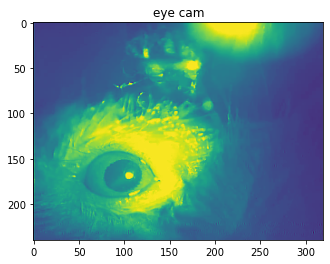

In [30]:
eye_data = xr.open_dataset(eye_file)
eye_vid = np.uint8(eye_data['REYE_video'])
plt.imshow(eye_vid[0,:,:]); plt.title('eye cam')
eyeT = eye_data.timestamps.copy()
eye_params = eye_data['REYE_ellipse_params']
th = np.array((eye_params.sel(ellipse_params = 'theta')-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi')-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)
omega = np.array(eye_data['REYE_eye_pupil_rotation'])*180/np.pi

In [31]:
eye_data

<xarray.Dataset>
Dimensions:              (ellipse_params: 7, frame: 78706, height: 240, point_loc: 30, width: 320)
Coordinates:
  * frame                (frame) int64 0 1 2 3 4 ... 78702 78703 78704 78705
  * point_loc            (point_loc) object 'pt1_x' ... 'outer_likelihood'
    timestamps           (frame) float64 ...
  * ellipse_params       (ellipse_params) object 'theta' 'phi' ... 'ellipse_phi'
Dimensions without coordinates: height, width
Data variables:
    REYE_pts             (frame, point_loc) float64 ...
    REYE_ellipse_params  (frame, ellipse_params) float64 ...
    REYE_video           (frame, height, width) int8 8 50 44 45 ... 44 44 44 44

In [8]:
ephys_data = pd.read_json(ephys_file)
ephysT0 = ephys_data.iloc[0,12]

In [14]:
# load IMU data
if free_move & has_imu:
    imu_data = xr.open_dataset(imu_file)
    accT = imu_data.timestamps
    acc_chans = imu_data.IMU_data
    gx = np.array(acc_chans.sel(channel='gyro_x'))
    gy = np.array(acc_chans.sel(channel='gyro_y'))
    gz = np.array(acc_chans.sel(channel='gyro_z'))

In [15]:
eyeT = eye_data.timestamps  - ephysT0
if eyeT[0]<-600:
    eyeT = eyeT + 8*60*60 # 8hr offset for some data
worldT = world_data.timestamps - ephysT0
if worldT[0]<-600:
    worldT = worldT + 8*60*60
if free_move & has_imu:
    accTraw = imu_data.timestamps-ephysT0
if (free_move==False) & has_mouse:
    speedT = spd_tstamps-ephysT0
eyeT, worldT

(<xarray.DataArray 'timestamps' (frame: 107302)>
 array([-9.87981250e-01, -9.73158750e-01, -9.57133250e-01, ...,
         1.78929638e+03,  1.78931241e+03,  1.78932844e+03])
 Coordinates:
   * frame       (frame) int64 0 1 2 3 4 5 ... 107297 107298 107299 107300 107301
     timestamps  (frame) float64 4.155e+04 4.155e+04 ... 4.334e+04 4.334e+04,
 <xarray.DataArray 'timestamps' (frame: 107305)>
 array([-9.97978250e-01, -9.88825750e-01, -9.72800250e-01, ...,
         1.78930450e+03,  1.78932044e+03,  1.78933646e+03])
 Coordinates:
   * frame       (frame) int64 0 1 2 3 4 5 ... 107300 107301 107302 107303 107304
     timestamps  (frame) float64 4.155e+04 4.155e+04 ... 4.334e+04 4.334e+04)

In [17]:
offset0 = 0.1;
drift_rate = 0.1/1000;
if free_move & has_imu:
    accT= accTraw - (offset0 + accTraw*drift_rate)

In [ ]:
if free_move:
        print('getting worldcam correction')
        number_of_iterations = 5000
        termination_eps = 1e-4
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
        warp_mode = cv2.MOTION_TRANSLATION
        max_frames = 60*300
        cc = np.zeros(max_frames); xshift = np.zeros(max_frames); yshift = np.zeros(max_frames);
        # get shift between adjacent frames
        for i in tqdm(range(max_frames)):
            warp_matrix = np.eye(2, 3, dtype=np.float32)
            (cc[i], warp_matrix) = cv2.findTransformECC (world_vid[i,:,:],world_vid[i+1,:,:],warp_matrix, warp_mode, criteria, inputMask = None, gaussFiltSize = 1)
            xshift[i] = warp_matrix[0,2]; yshift[i] = warp_matrix[1,2]

        th_interp = interp1d(eyeT,th,bounds_error = False)
        phi_interp = interp1d(eyeT, phi, bounds_error = False)
        dth = np.diff(th_interp(worldT))
        dphi = np.diff(phi_interp(worldT))
        plt.figure(figsize = (12,8))
        plt.subplot(2,2,1)
        plt.plot(dth[0:max_frames],xshift[0:max_frames],'.');plt.plot([-5, 5], [5, -5],'r'); plt.xlim(-8,8); plt.ylim(-6,6); plt.xlabel('dtheta'); plt.ylabel('xshift')
        plt.subplot(2,2,2)
        plt.plot(dth[0:max_frames],yshift[0:max_frames],'.');plt.plot([-5, 5], [5, -5],'r'); plt.xlim(-8,8); plt.ylim(-6,6); plt.xlabel('dtheta'); plt.ylabel('yshift')
        plt.subplot(2,2,3)
        plt.plot(dphi[0:max_frames],xshift[0:max_frames],'.');plt.plot([-5, 5], [5, -5],'r'); plt.xlim(-8,8); plt.ylim(-6,6); plt.xlabel('dphi'); plt.ylabel('xshift')
        plt.subplot(2,2,4)
        plt.plot(dphi[0:max_frames],yshift[0:max_frames],'.');plt.plot([-5, 5], [5, -5],'r'); plt.xlim(-8,8); plt.ylim(-6,6); plt.xlabel('dphi'); plt.ylabel('yshift')
        plt.tight_layout()
        diagnostic_pdf.savefig()
        plt.close()

        plt.figure()
        plt.subplot(3,1,1)
        plt.plot(worldT[0:max_frames],cc); plt.ylabel('cc')
        if file_dict['imu'] is not None:
            plt.subplot(3,1,2)
            plt.plot(worldT[0:max_frames],xshift, label = 'image x shift');
            plt.plot(accT,-(gz-2.9)*7.5, label = 'gyro')
            #plt.plot(worldT[0:max_frames],yshift, label = 'y');
            #plt.plot(eyeT[0:-1],-dEye,label = 'eye dtheta')
            plt.xlim(0,2); plt.ylim(-2,2)
            plt.xlabel('secs'); plt.ylabel('deg')
            plt.legend()
        plt.subplot(3,1,3)
        plt.plot(worldT[0:max_frames],xshift, label = 'image x shift');
        #plt.plot(accT,-(gz-2.9)*7.5, label = 'gyro')
        #plt.plot(worldT[0:max_frames],yshift, label = 'y');
        plt.plot(worldT[0:-1],-dphi,'r',label = 'eye dtheta', alpha = 1)
        plt.xlim(0,2); plt.ylim(-0.5,0.5)
        plt.xlabel('secs'); plt.ylabel('deg')
        plt.legend()
        plt.tight_layout()
        diagnostic_pdf.savefig()
        plt.close()

        xmodel = LinearRegression()
        ymodel = LinearRegression()
        eyeData = np.zeros((max_frames,2))
        eyeData[:,0] = dth[0:max_frames];
        eyeData[:,1] = dphi[0:max_frames];
        xshiftdata = xshift[0:max_frames];
        yshiftdata = yshift[0:max_frames];
        usedata = ~np.isnan(eyeData[:,0]) & ~np.isnan(eyeData[:,1])  & (np.abs(eyeData[:,0])<2) & (np.abs(eyeData[:,1])<2)
        xmodel.fit(eyeData[usedata,:],xshiftdata[usedata])

        #offset0 = xmodel.intercept
        xmap = xmodel.coef_;
        print(xmap)

        ymodel.fit(eyeData[usedata,:],yshiftdata[usedata])
        ymap = ymodel.coef_;

    else:
        xmap = [-0.080764229, -0.075781153]
        ymap =[-0.076365844,  0.083263225]

    # eye correction movie
    print('getting eye correction movie')
    tr = [15,20]
    fig = plt.figure(figsize = (8,16))
    gs = fig.add_gridspec(10,1)
    axEye = fig.add_subplot(gs[0,0])
    axWorld = fig.add_subplot(gs[0:3,:])
    axWorldFix = fig.add_subplot(gs[3:6,:])

    axTheta = fig.add_subplot(gs[6,:])
    axPhi = fig.add_subplot(gs[7,:])
    axOmega = fig.add_subplot(gs[8,:])
    axGyro = fig.add_subplot(gs[9,:])

    th = np.array((eye_params.sel(ellipse_params = 'theta')-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
    phi = np.array((eye_params.sel(ellipse_params = 'phi')-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)

    axTheta.plot(eyeT,th)
    axTheta.set_xlim(tr[0],tr[1]); 
    axTheta.set_ylabel('theta - deg'); axTheta.set_ylim(-30,30)

    axPhi.plot(eyeT,phi)
    axPhi.set_xlim(tr[0],tr[1]); 
    axPhi.set_ylabel('phi - deg'); axPhi.set_ylim(-30,30)

    #axOmega.plot(eyeT,omega)
    axOmega.set_xlim(tr[0],tr[1]); 
    axOmega.set_ylabel('omega - deg'); axOmega.set_ylim(-20,20)

    if free_move & has_imu:
        axGyro.plot(accT,gz)
        axGyro.set_xlim(tr[0],tr[1]); 
        axGyro.set_ylabel('gyro - deg'); axGyro.set_ylim(1,4)

    thInterp =interp1d(eyeT,th)
    phiInterp =interp1d(eyeT,phi)
    pix_per_deg = 1.6

    vidfile = os.path.join(file_dict['save'], (file_dict['name']+'_unit'+str(this_unit)+'_corrected.mp4'))
    # now animate
    writer = FFMpegWriter(fps=30)
    with writer.saving(fig, vidfile, 100):
    #    for t in np.arange(tr[0],tr[1],1/30):
        for t in tqdm(worldT[(worldT>tr[0]) & (worldT<tr[1])]):        
            # show eye and world frames
            axEye.cla(); axEye.axis('off'); 
            axEye.imshow(eyeInterp(t),'gray',vmin=0,vmax=255,aspect = "equal")
            #axEye.set_xlim(0,160); axEye.set_ylim(0,120)
            
            world = worldInterp(t)
            axWorld.cla(); axWorld.axis('off'); 
            axWorld.imshow(world,'gray',vmin=0,vmax=255,aspect = "equal")
            
            worldFix= np.roll(world,(-np.int8(thInterp(t)*ymap[0] + phiInterp(t)*ymap[1]),-np.int8(thInterp(t)*xmap[0] + phiInterp(t)*xmap[1])),axis = (0,1))
            axWorldFix.imshow(worldFix,'gray',vmin=0, vmax = 255, aspect = 'equal')
            
            #plot line for time, then remove
            ln1 = axTheta.vlines(t,-0.5,30,'b')
            ln2 = axPhi.vlines(t,-0.5,30,'b')
            writer.grab_frame()
            ln1.remove()
            ln2.remove()
        

    max_frames = 60*60
    thInterp =interp1d(eyeT,th, bounds_error = False, fill_value = 0)
    phiInterp =interp1d(eyeT,phi, bounds_error = False, fill_value = 0)

    world_fix = np.zeros((max_frames, np.size(world_vid,1), np.size(world_vid,2)),'uint8')
    for f in tqdm(range(max_frames)):
        t = worldT[f]
        thInt = thInterp(t)
        if np.isnan(thInt):
            thInt =0
        phiInt = phiInterp(t) 
        if np.isnan(phiInt):
            phiInt =0
                
        world_fix[f,:,:]= imshift(world_vid[f,:,:],(-(thInt*ymap[0] + phiInt*ymap[1]),-(thInt*xmap[0] + phiInt*xmap[1])))

    number_of_iterations = 5000
    termination_eps = 1e-4
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
    warp_mode = cv2.MOTION_TRANSLATION
    cc_fix = np.zeros(max_frames); xshift_fix = np.zeros(max_frames); yshift_fix = np.zeros(max_frames);
    for i in tqdm(range(max_frames-1)):
        try:
            warp_matrix = np.eye(2, 3, dtype=np.float32)
            (cc_fix[i], warp_matrix) = cv2.findTransformECC (world_fix[i,:,:],world_fix[i+1,:,:],warp_matrix, warp_mode, criteria, inputMask = None, gaussFiltSize = 1)
            xshift_fix[i] = warp_matrix[0,2]; yshift_fix[i] = warp_matrix[1,2]
        except:
            xshift_fix[i] = np.nan; yshift_fix[i] = np.nan # very rarely, a frame will raise cv2 error when iterations do not converge for transform

    if free_move:
        plt.figure()
        plt.subplot(2,1,1)
        plt.plot(xshift,label = 'x pre alignment')
        plt.plot(xshift_fix,label = 'x post alignement')
        plt.ylim(-5,5); plt.xlim(1000,1500)

        plt.subplot(2,1,2)
        plt.plot(yshift,label = 'y pre alignment')
        plt.plot(yshift_fix, label = 'y post alignement')
        plt.ylim(-5,5); plt.xlim(1000,1500)

        diagnostic_pdf.savefig()
        plt.close()

    max_frame = 60*60
    flow = np.zeros((max_frame, np.size(world_vid,1), np.size(world_vid,2),2))
    flow_fix = np.zeros((max_frame, np.size(world_vid,1), np.size(world_vid,2),2))
    x,y = np.meshgrid(np.arange(0, np.size(world_vid,2)), np.arange(0,np.size(world_vid,1)))
    vidfile = os.path.join(file_dict['save'], (file_dict['name']+'_flowfix.mp4'))

    print('plotting video of optical flow')
    fig, axs = plt.subplots(1,2,figsize = (16,8))
    # now animate
    writer = FFMpegWriter(fps=30)
    nx = 5
    with writer.saving(fig, vidfile, 100):
        for f in tqdm(range(max_frame-1)):

            flow[f,:,:,:] = cv2.calcOpticalFlowFarneback(world_vid[f,:,:],world_vid[f+1,:,:], None, 0.5, 3, 15, 3, 5, 1.2, 0)
            axs[0].cla()
            axs[0].imshow(world_vid[f,:,:],vmin = 0, vmax = 255)
            u = flow[f,:,:,0]; v = flow[f,:,:,1]
            axs[0].quiver(x[::nx,::nx],y[::nx,::nx],u[::nx,::nx],-v[::nx,::nx], scale = 100 )
            
            flow_fix[f,:,:,:] = cv2.calcOpticalFlowFarneback(world_fix[f,:,:],world_fix[f+1,:,:], None, 0.5, 3, 15, 3, 5, 1.2, 0)
            axs[1].cla()
            axs[1].imshow(world_fix[f,:,:],vmin = 0, vmax = 255)
            u = flow_fix[f,:,:,0]; v = flow[f,:,:,1]
            axs[1].quiver(x[::nx,::nx],y[::nx,::nx],u[::nx,::nx],-v[::nx,::nx], scale = 100 )
            
            writer.grab_frame()